In [935]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [936]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [937]:
import mne

In [938]:
import pandas as pd

In [939]:
from scipy.io import loadmat

In [940]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [942]:
subject = "S5"

In [943]:
session = loadmat('data/{}.mat'.format(subject))

In [944]:
session

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 25 11:26:40 2020',
 '__version__': '1.0',
 'fs': array([[250]], dtype=uint8),
 'trig': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=int16),
 'y': array([[ -7.30613625,   1.3315682 , -10.83861505, ...,  -4.27406039,
           1.30017107,   6.11832613],
        [ -8.48543913,   1.73635348,  -7.95181543, ...,  -1.67533302,
           2.46804612,   7.07319667],
        [ -9.7031921 ,   1.60667916,  -4.40113701, ...,   3.08787224,
           3.56190653,   7.76033321],
        ...,
        [ 25.7026211 ,  -6.42408369,   1.68372238, ...,  18.96521821,
         -12.49643695,  -0.15902938],
        [ 26.35654495,  -5.34583461,   3.29601472, ...,  18.39830268,
         -10.26110472,  -0.10157686],
        [ 26.37334077,  -4.94438258,   4.37500684, ...,  17.90661394,
          -8.56603912,   0.06784526]])}

In [945]:
channels = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [946]:
session_df = pd.DataFrame(session["y"], columns=channels)

In [947]:
sfreq = session["fs"][0][0]

In [948]:
session_df["Time"] = session_df.index / session["fs"][0][0]

In [949]:
session_df["Trigger"] = session["trig"]
session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2

# Whitening

In [950]:
# from sklearn.decomposition import PCA

In [951]:
# pca = PCA(whiten=True)

In [952]:
# features_matrix = pca.fit_transform(session_df[channels], )

In [953]:
# for index, channel in enumerate(channels):
#     session_df[channel] = features_matrix.T[index]

# Restore raw

In [954]:
channels += ['Trigger']

In [955]:
info = mne.create_info(ch_names=channels, sfreq=sfreq)

In [956]:
raw = mne.io.RawArray(session_df[channels].values.T, info)

Creating RawArray with float64 data, n_channels=9, n_times=60855
    Range : 0 ... 60854 =      0.000 ...   243.416 secs
Ready.


In [957]:
channel_types = {c: 'eeg' for c in channels}
channel_types['Trigger'] = 'stim'

In [958]:
raw.set_channel_types(channel_types)

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-958-656cff14ccc4>:1: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


# Pipeline

In [959]:
def plot_raw(raw, start=0, stop=240):
    rcParams['figure.figsize'] = 20, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=8,
        scalings={'eeg': 100}
    )
    plt.show()

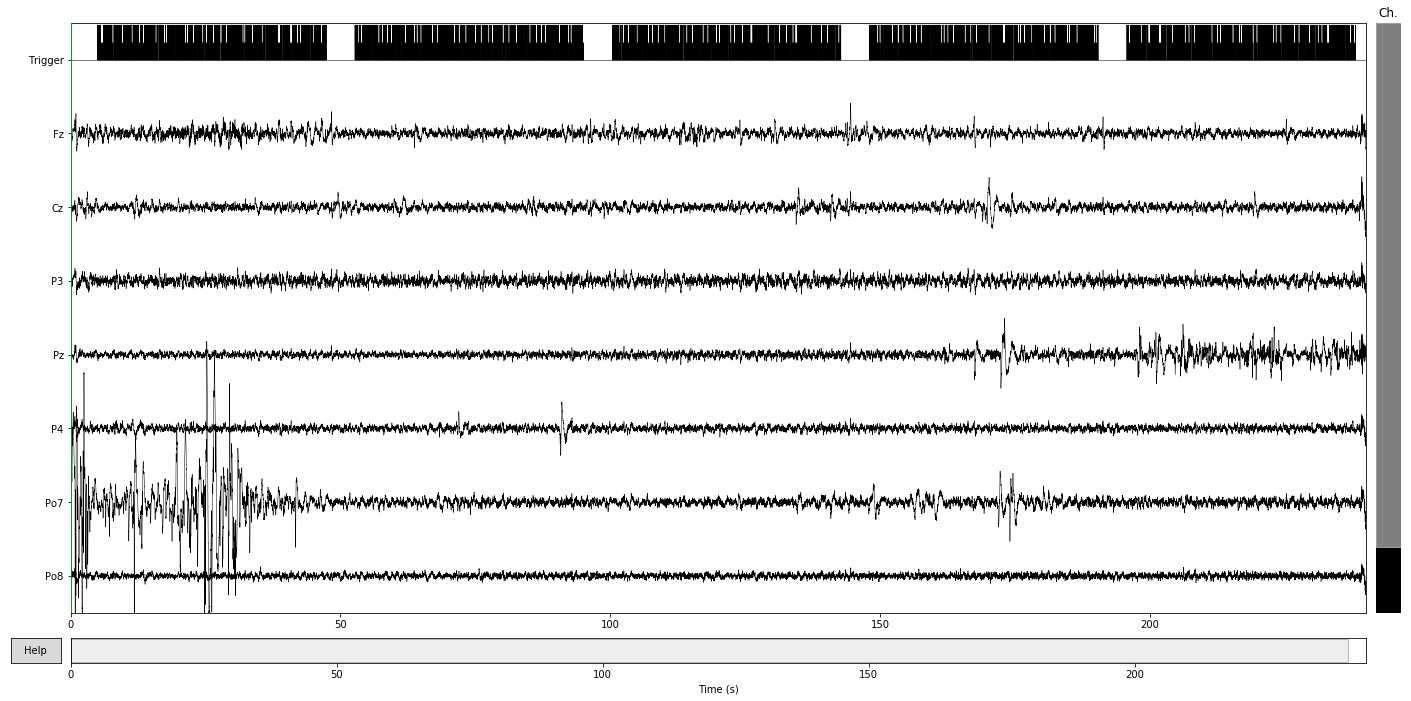

In [960]:
plot_raw(raw)

In [961]:
raw.filter(0.5, 30)

Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


<RawArray  |  None, n_channels x n_times : 9 x 60855 (243.4 sec), ~4.2 MB, data loaded>

Other kind of filtering - when the amplitude > a + std, then mark epoch as bad

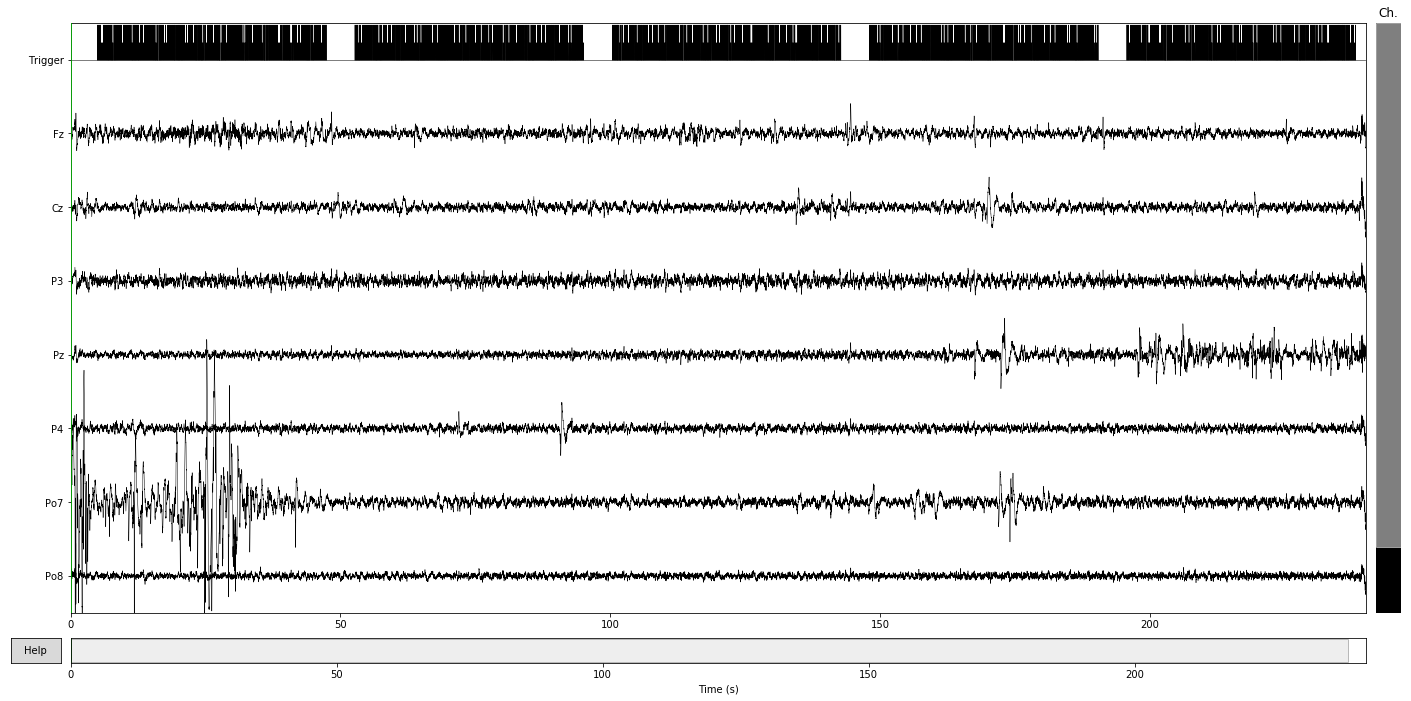

In [962]:
plot_raw(raw)

In [963]:
events

array([[ 1250,     0,     2],
       [ 1294,     0,     2],
       [ 1339,     0,     1],
       ...,
       [59385,     0,     2],
       [59430,     0,     2],
       [59473,     0,     2]])

In [964]:
events = mne.find_events(raw, 'Trigger')

1200 events found
Event IDs: [1 2]


In [965]:
def get_epochs(raw):
    global events
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
        reject_by_annotation=False,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs.decimate(12)

In [966]:
epochs = get_epochs(raw)

1200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1200 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-965-298b03c8cc96>:10: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
  return epochs.decimate(12)


In [967]:
epochs.event_id

{'1': 1, '2': 2}

In [968]:
true_events = epochs['1'].get_data()

In [969]:
false_events = epochs['2'].get_data()

In [970]:
y = [1] * true_events.shape[0] + [0] * false_events.shape[0]

In [971]:
X = np.vstack([true_events, false_events]).reshape(len(y), -1)

In [972]:
X.shape

(1200, 136)

## Model

In [973]:
from sklearn.model_selection import GridSearchCV

In [974]:
model = LDA()
grid = {'solver': ['svd']}
search = GridSearchCV(model, grid, cv=3, scoring='accuracy')

In [975]:
search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['svd']}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='accuracy', verbose=0)

In [976]:
search.best_score_

0.9091666666666667

Here is a description of LDA pipeline from the paper above:
- power-based artifact rejection
- band-pass 0.5-30Hz
- decimation by a factor of 12
- whitening
- trials extraction, from -100ms to 700ms, for each stimulus
- 120-dimensional LDA
- 200 repetitions of randomized cross-validation

# Pipeline improvements

- Implement whitening
- Implement TVLDA

# Perform ICA filtering

In [196]:
ica = mne.preprocessing.ICA()

In [197]:
ica.fit(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.5s.


<ICA  |  raw data decomposition, fit (fastica): 60782 samples, 8 components, channels used: "eeg">

In [198]:
ica_eeg = ica.get_sources(raw)

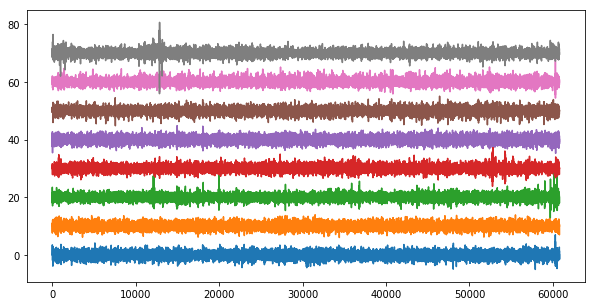

In [199]:
plt.figure(figsize=(10, 5))
plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

In [201]:
filtered_eeg = ica.apply(raw.copy(), exclude=[])

Transforming to ICA space (8 components)
Zeroing out 0 ICA components


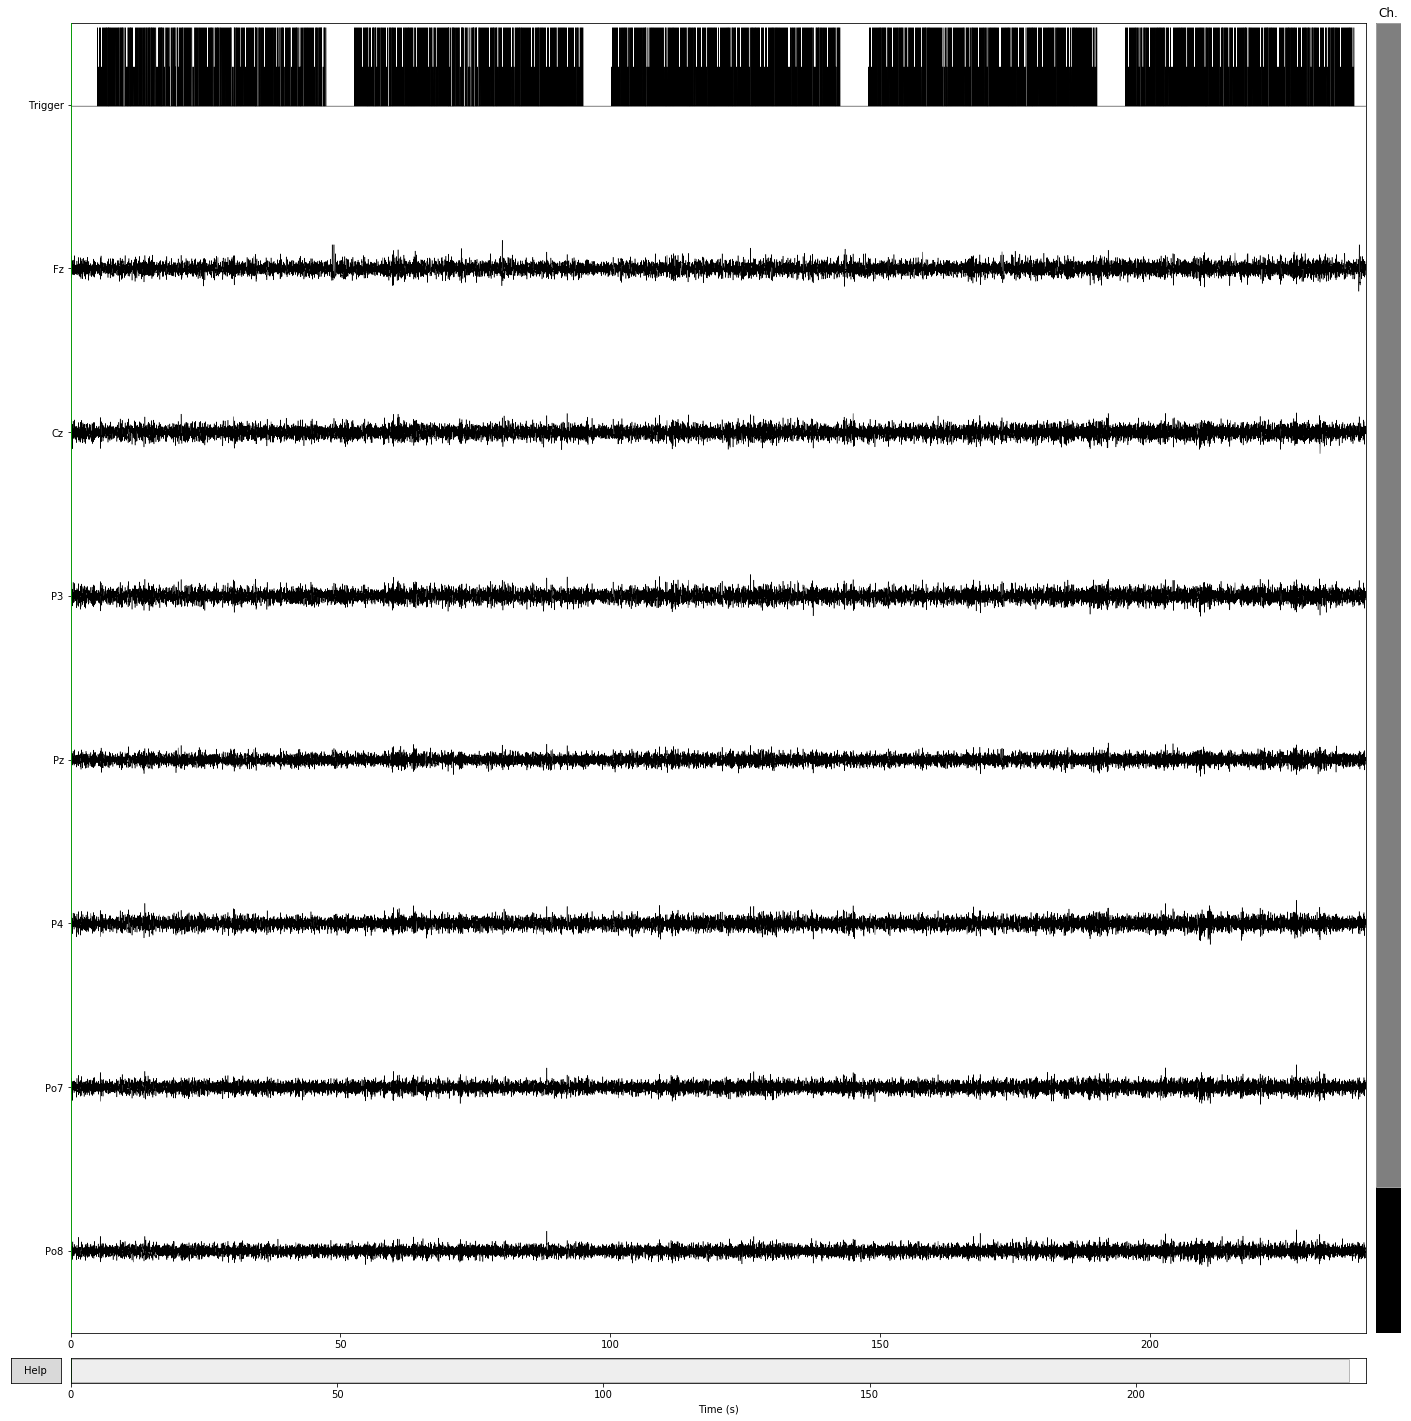

In [202]:
rcParams['figure.figsize'] = 20, 20
mne.viz.plot_raw(
    filtered_eeg, 
    start=start, 
    duration=stop - start, 
    show=False, 
    n_channels=8,
    scalings={'eeg': 100}
)
plt.show()

# 

In [203]:
events = mne.find_events(filtered_eeg, 'Trigger')

1200 events found
Event IDs: [1 2]


In [204]:
def get_epochs(raw, event_id):
    global events
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, event_id=event_id, tmin=-0.1, tmax=0.5)
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs

150 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-205-bb90cc5b171d>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  get_epochs(filtered_eeg, 1).average().plot()


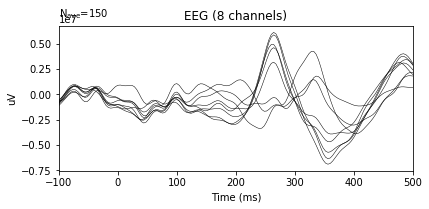

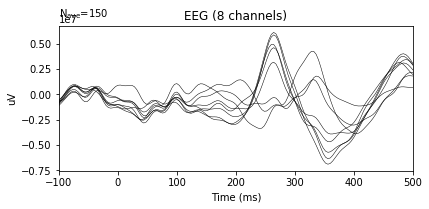

In [205]:
get_epochs(filtered_eeg, 1).average().plot()

1050 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-206-65244dadd8c0>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  get_epochs(filtered_eeg, 2).average().plot()


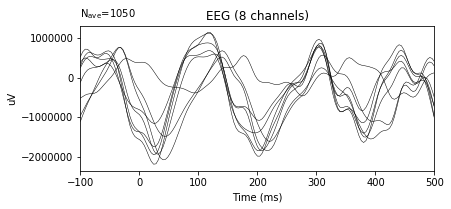

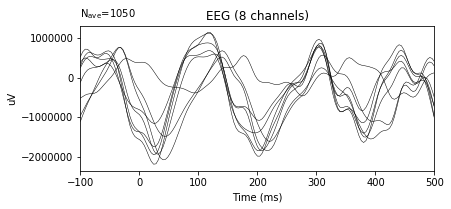

In [206]:
get_epochs(filtered_eeg, 2).average().plot()

# Applying LDA to discriminate